# Deep Learning
In this exercise, you will practice using deep learning with artificial neural networks and the Pytorch library to build classification models. Note that Pytorch is **not** included in the Anaconda distribution by default. You have two options for using Pytorch to complete this assignment:

1. Install Pytorch locally (for free). You can see the directions on the [Pytorch website here](https://pytorch.org/get-started/locally/). Select the stable build, your operating system, Conda (for Anaconda), Python, and CPU to see install directions for your particular setup. (CUDA is used to support hardware acceleration with NVIDIA graphics cards and is not necessary for this course).
2. Use Pytorch in a Jupyter notebook in the cloud (also for free). The easiest way to do this is with a Google colab notebook; Pytorch will already be available to you in this cloud environment. If you choose this option, go to the [Google colab website](https://colab.research.google.com) select "Upload" at the right side of the orange menu bar, and select this `.ipynb` file. You can then complete the assignment in colab and download the completed `.ipynb` file to turn in on Gradescope.

### Question 1: The Data
First, we import the necessary libraries and download the `CIFAR-10` dataset from Pytorch. The `CIFAR-10` dataset consists of 60,000 32 by 32 pixel color images in 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images. The classes of the images are things like `airplane`, `automobile`, `bird`, `cat`, `deer`, etc. You can read more about the dataset at the [curator's website](https://www.cs.toronto.edu/~kriz/cifar.html). 

Run the following code to import necessary libraries, download the data, and preview some of the images along with their classes. **Note that this step may take a few minutes depending on your internet speed**; the dataset is about 160 MB. Once you have downloaded the data once, rerunning the cell should be fast; it will verify that you already have the dataset rather than redownload every time.

In [1]:
# Imports all of the necessary Pytorch libraries

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

ModuleNotFoundError: No module named 'torch'

In [ ]:
# Run but do not modify this code
# Downloads, imports, and formats the CIFAR-10 image dataset. 
# May take a few minutes the first time you run it

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_dataloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


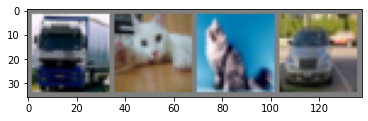

truck   cat   cat   car


In [ ]:
# Displays random images from the CIFAR-10 image dataset

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_dataloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
plt.show()

After running this code, `images` is a tensor containing the images displayed above. Run the code below to see the shape of the tensor, which is 4 by 3 by 32 by 32. Explain these values: What do these numbers represent in terms of the data?

In [ ]:
# Run but do not modify this code
print(images.shape)

torch.Size([4, 3, 32, 32])


### Answer 1
The 32x32 is the number of pixels for images, weight by height. 3 means there are 3 colors, and 4 is the batch size (4 images at a gradient calculation step). 


### Question 2
Now we will start by defining a (relatively) small multilayer perceptron for classifying these images.

In [ ]:
# Defines a multilayer perceptron class

class MultilayerPerceptron(nn.Module):
    def __init__(self):
        super(MultilayerPerceptron, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(32*32*3, 100),
            nn.ReLU(),
            nn.Linear(100, 25),
            nn.ReLU(),
            nn.Linear(25, 10),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

Answer the following questions about this `MultilayerPerceptron` defined in the code above.
1. How many neurons are there in the input layer of the neural network?
2. How many **hidden** (that is, apart from the input and output layers) fully connected linear layers are there in the network?
3. What nonlinear activation function is the network using?
4. How many parameters are there for the connection between the input layer and the first hidden fully connected layer in the network?

### Answer 2
1. There are 3072 neurons in the input layer of the neural network, because the images in CIFAR-10 are of size 3x32x32 and 3 * 32 * 32 = 3072. 
2. 2 hidden fully connected linear layers are in the network. Note that hidden fully-connected layers are in between input and output layers (hidden) and have weights connected to all of the outputs of the previous layer (fully-connected). Generally, 2 hidden layers will enable the network to model any arbitrary function.
3. The nonlinear activation function the network is using is ReLU, which stands for rectified linear unit. In short, ReLU is a piecewise linear function that will output the input directly if it is positive, otherwise, it will output zero.
4. 32 * 32 * 3* 100 = 307200 parameters.


### Question 3
Now we define our hyperparameters, initialize our model and optimizer, and define our training and testing process. The training uses stochastic gradient descent and prints the average training loss after every 1,250 batches or 5,000 images. After each of three epochs of training we print the average accuracy of the model on the held out test data; this is the percentage of the test images that our model correctly classifies.

In [ ]:
# Defines hyperparameters 

torch.manual_seed(216)
learning_rate = 1e-3
epochs = 3

In [ ]:
# Initializes the network, loss function, and optimizer

model = MultilayerPerceptron()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
# Defines the training optimization process and
# calculating accuracy on the held out testing data

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    avg_batch_loss = 0.0
    for batch, (X, y) in enumerate(dataloader):
        
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_batch_loss += loss.item()

        # Print average loss every 1250 batches
        if ((batch > 0) and (batch % 1250 == 0)):
            loss, current = loss.item(), batch * len(X)
            print(f"Average Loss: {avg_batch_loss/1250:>7f}  [{current:>5d}/{size:>5d}]")
            avg_batch_loss = 0.0
            
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
# Performs 'epochs' of training with stochastic
# gradient descent, printing average loss of every
# 1250 batches. Prints test accuracy after each
# epoch.
# NOTE: Optimization on 50,000 training samples may take
# some time, expect this code to run for several seconds 
# to a couple of minutes.

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
Average Loss: 2.289803  [ 5000/50000]
Average Loss: 2.271758  [10000/50000]
Average Loss: 2.250825  [15000/50000]
Average Loss: 2.228202  [20000/50000]
Average Loss: 2.217166  [25000/50000]
Average Loss: 2.201424  [30000/50000]
Average Loss: 2.180412  [35000/50000]
Average Loss: 2.162303  [40000/50000]
Average Loss: 2.131566  [45000/50000]
Test Error: 
 Accuracy: 28.3%, Avg loss: 0.524307 

Epoch 2
-------------------------------
Average Loss: 2.098934  [ 5000/50000]
Average Loss: 2.088876  [10000/50000]
Average Loss: 2.068757  [15000/50000]
Average Loss: 2.028127  [20000/50000]
Average Loss: 2.032686  [25000/50000]
Average Loss: 2.010879  [30000/50000]
Average Loss: 2.048582  [35000/50000]
Average Loss: 2.001798  [40000/50000]
Average Loss: 2.005557  [45000/50000]
Test Error: 
 Accuracy: 32.7%, Avg loss: 0.496590 

Epoch 3
-------------------------------
Average Loss: 1.970746  [ 5000/50000]
Average Loss: 1.986225  [10000/50000]
Average Loss: 1.

Answer the following questions about the training/testing in the code above.
1. There are 10 neurons in the output layer of the model. How does the code in `test_loop` predict a single class as an integer given the 10 values output by the model during forward propagation?
2. After 3 epochs of training, is our model performing better than randomly guessing the class? If so, how much?
3. Suppose we double the sizes of the hidden fully connected layers in the model. Would you expect the model to achieve better (lower) or worse (higher) loss during training? Briefly explain your answer.
4. Again suppose we double the sizes of the hidden fully connected layers in the model. Would you expect training the model with stochastic gradient descent over two epochs to take less or more time? Briefly explain your answer.

### Answer 3
1. The code in test_loop predicts a single class as an integer by iteratively adjusting the test_lost and correct variable to eventually finalize the prediction. 
2. Yes, our model accuracy is 35.1%, which is considerably higher than the accuracy from randomly guessing, 10%. 
3. Better (lower) loss during training, because as more layers using certain activation functions are added to neural networks, the gradients of the loss function decrease (towards zero).
4. More time, because an inordinately large number of neurons in the hidden layers can increase the time it takes to train the network. In some cases, the amount of training time can increase to the point that it is impossible to adequately train the neural network.

### Question 4 (optional, 0 points)
Now we define a convolutional neural network for the same classification task.

In [13]:
# Defines a convolutional neural network class

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv_pool_stack = nn.Sequential(
            nn.Conv2d(3, 6, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(16*5*5, 100),
            nn.ReLU(),
            nn.Linear(100, 25),
            nn.ReLU(),
            nn.Linear(25, 10),
            nn.ReLU()
        )

    def forward(self, x):
        convolved = self.conv_pool_stack(x)
        flattened = self.flatten(convolved)
        logits = self.linear_relu_stack(flattened)
        return logits

Answer the following questions about the `ConvNet` class defined in the code above.
1. The first hidden fully connected linear layer in the network, after convolving, pooling, and flattening, has $16 \times 5 \times 5 = 400$ neurons. This is much less than the size of the input for the `MultilayerPerceptron` model. What part of the `ConvNet` most accounts for this reduction in the input size? 
2. Are there more parameters in the `conv_pool_stack` or the `linear_relu_stack` portions of the network? Briefly explain your answer, but you do not need to give the exact number of parameters.
3. Does this model have more or fewer total parameters than the `MultilayerPerceptron` defined previously? Briefly explain your answer, but you do not need to give the exact number of parameters.

### Answer 4
*Write your answer to question 4 here*


### Question 5
Now we define our hyperparameters, initialize our model and optimizer, and define our training and testing process. As for the `MultilayerPerceptron`, the training uses stochastic gradient descent and prints the average training loss after every 1,250 batches or 5,000 images. After each of three epochs of training we print the average accuracy of the model on the held out test data; this is the percentage of the test images that our model correctly classifies.

In [14]:
torch.manual_seed(216)
learning_rate = 1e-3
epochs = 3
conv_model = ConvNet()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(conv_model.parameters(), lr=learning_rate)

In [15]:
# Performs 'epochs' of training with stochastic
# gradient descent, printing average loss of every
# 1250 batches. Prints test accuracy after each
# epoch.
# NOTE: Optimization on 50,000 training samples may take
# some time, expect this code to run for several seconds 
# to a couple of minutes.

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, conv_model, loss_fn, optimizer)
    test_loop(test_dataloader, conv_model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
Average Loss: 2.306474  [ 5000/50000]
Average Loss: 2.303100  [10000/50000]
Average Loss: 2.302822  [15000/50000]
Average Loss: 2.301417  [20000/50000]
Average Loss: 2.299124  [25000/50000]
Average Loss: 2.297577  [30000/50000]
Average Loss: 2.295971  [35000/50000]
Average Loss: 2.293259  [40000/50000]
Average Loss: 2.289070  [45000/50000]
Test Error: 
 Accuracy: 19.9%, Avg loss: 0.570469 

Epoch 2
-------------------------------
Average Loss: 2.278848  [ 5000/50000]
Average Loss: 2.261517  [10000/50000]
Average Loss: 2.227377  [15000/50000]
Average Loss: 2.190690  [20000/50000]
Average Loss: 2.152202  [25000/50000]
Average Loss: 2.134838  [30000/50000]
Average Loss: 2.075648  [35000/50000]
Average Loss: 1.994549  [40000/50000]
Average Loss: 1.947703  [45000/50000]
Test Error: 
 Accuracy: 30.9%, Avg loss: 0.474452 

Epoch 3
-------------------------------
Average Loss: 1.899949  [ 5000/50000]
Average Loss: 1.878731  [10000/50000]
Average Loss: 1.

Answer the following questions about this the training/testing in the code above.
1. Compare the results with the `ConvNet` to those obtained with the `MultilayerPerceptron`. In particular, what difference do you observe about the training loss of the two models during the third epoch of training?
2. Based on your observation of the training loss of the `ConvNet` during the third epoch of training, do you think increasing the `learning_rate` (the step size of stochastic gradient descent) somewhat (say, from 0.001 to 0.01) would result in better or worse accuracy during testing after three epochs of training? Briefly explain your answer. 

### Answer 5
- 1. Training loss is lower with the ConvNet than MultilayerPerception.
- 2. Increasing learning rate (step size of stochastic gradient descent) would improve accuracy after 3 epochs, because we know the following:
- A large step size tends to make the algorithm converge to a global minimum
- A large step size tends to make the algorithm diverge when the function value is changing very quickly
- A large step size tends to make the algorithm converge only where a local minimum is close in function value to the global minimum
- A large step size increases the variance of the parameter estimates
